In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler
import line_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt


from HOTS.Monitor import GenerateAM, DisplayAM
from HOTS.Event import Event, SimpleAlphabet
from HOTS.STS import STS
from HOTS.Layer import ClusteringLayer, FilterNHBD
from HOTS.Monitor import DisplayImage, DisplaySurface3D, DisplaySurface2D, DisplayConvergence
from HOTS.Tools import SaveObject, LoadObject
from HOTS.Classifier import Classifier
from HOTS.Network import Network
from HOTS.Cluster import KmeansMaro

In [3]:
tau = 0.02
R = 2
nb_cluster = 4
ImageSize = (32,32)
KN=2

# Loading of the stream of event

In [14]:
%lprun -f SimpleAlphabet \
event_tr,event_te,event_cl,label_tr, label_te = SimpleAlphabet(NbTrainingData=36, NbTestingData=40,\
                                                               Path='../Data/ExtractedStabilized.mat',\
                                                               LabelPath='../Data/alphabet_label.pkl',\
                                                               ClusteringData=[1, 32, 19, 22, 29],\
                                                               OutOnePolarity = False, verbose=0)

In [15]:
%lprun -f event_tr.LoadFromMat \
event_tr,event_te,event_cl,label_tr, label_te = SimpleAlphabet(NbTrainingData=36, NbTestingData=40,\
                                                               Path='../Data/ExtractedStabilized.mat',\
                                                               LabelPath='../Data/alphabet_label.pkl',\
                                                               ClusteringData=[1, 32, 19, 22, 29],\
                                                               OutOnePolarity = False, verbose=0)

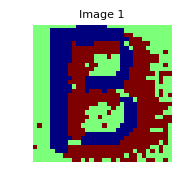

In [16]:
DisplayImage([event_cl],multi_image=4)

Result Of time Optimization : 
V1 : 1.19s ... V2 : 0.91s ... V3 : 0.26s

# Clustering

In [27]:
## Defining the network
L1 = ClusteringLayer(tau=tau, R=R, verbose=0, mode='Maro', ThrFilter=2)
L2 = ClusteringLayer(tau=10*tau, R=2*R, verbose=0, mode='Maro', ThrFilter=2)
L3 = ClusteringLayer(tau=10*10*tau, R=2*2*R, verbose=0, mode='Maro', ThrFilter=2)
Net = Network([L1,L2,L3])

In [28]:
%lprun -f Net.TrainCluster \
ClusterLayer, event_output = Net.TrainCluster(event = event_cl,nb_cluster=nb_cluster, KN=KN, \
                                                 record_each=1000, NbCycle=1)

In [19]:
%lprun -f L1.TrainLayer \
ClusterLayer, event_output = Net.TrainCluster(event = event_cl,nb_cluster=nb_cluster, KN=KN, \
                                                 record_each=1000, NbCycle=1)

In [20]:
%lprun -f L1.ClusterLayer.fit \
ClusterLayer, event_output = Net.TrainCluster(event = event_cl,nb_cluster=nb_cluster, KN=KN, \
                                                 record_each=1000, NbCycle=1)

In [29]:
%lprun -f L1.ClusterLayer.predict \
ClusterLayer, event_output = Net.TrainCluster(event = event_cl,nb_cluster=nb_cluster, KN=KN, \
                                                 record_each=1000, NbCycle=1)

In [ ]:
%lprun -f L1.SpTe_Layer.create \
ClusterLayer, event_output = Net.TrainCluster(event = event_cl,nb_cluster=nb_cluster, KN=KN, \
                                                 record_each=1000, NbCycle=1)

In [ ]:
from HOTS.Tools import EuclidianNorm



a = L1.SpTe_Layer.Surface
print(a.shape)
proto = L1.ClusterLayer.prototype.T
print(proto.shape)
b = a[:,:,np.newaxis]-proto
print(b.shape)
norm1 = np.linalg.norm(b,axis=1)
print(norm1.shape)
pol1 = np.argmin(norm1,axis=1)
dist = np.amin(norm1,axis=1)
print('shape pol', pol1.shape)
print('shape dist', dist.shape)

%timeit L1.ClusterLayer.predict(L1.SpTe_Layer, event = event_tr)
event_out, out1 = L1.ClusterLayer.predict(L1.SpTe_Layer, event = event_tr)
print(out1)

def predictFast(proto, STS, event=None, SurfaceFilter=None):
    if SurfaceFilter == None:
        to_predict = STS.Surface
    else :
        random_selection = np.random.permutation(np.arange(STS.Surface.shape[0]))[:SurfaceFilter]
        to_predict = STS.Surface[random_selection]
        
    #polarity,output_distance = np.zeros(to_predict.shape[0]).astype(int),np.zeros(to_predict.shape[0])
    
    diff = to_predict[:,:,np.newaxis] - proto.T
    norm1 = np.linalg.norm(diff, axis=1)
    polarity = np.argmin(norm1,axis=1)
    output_distance = np.amin(norm1,axis=1)
    return output_distance

%timeit predictFast(L1.ClusterLayer.prototype,L1.SpTe_Layer)
distance = predictFast(L1.ClusterLayer.prototype,L1.SpTe_Layer)
print(distance)


    #to_predict
    
    #diff = to_predict[:,:,np.newaxis] - proto.T
    #norm1 = np.linalg.norm(diff, axis=1)
    #polarity = np.argmin(norm1,axis=1)
    #output_distance = np.amin(norm1,axis=1)
    #return output_distance


In [ ]:
import itertools
def predictFast1(proto, STS, event=None, SurfaceFilter=None,batch_size=10000):
    
    if SurfaceFilter == None:
        to_predict = STS.Surface
    else :
        random_selection = np.random.permutation(np.arange(STS.Surface.shape[0]))[:SurfaceFilter]
        to_predict = STS.Surface[random_selection]
        
    n_batch = to_predict.shape[0] // batch_size 
    batches = np.array_split(to_predict, n_batch)
    
    batches = itertools.cycle(batches)    
    polarity = np.zeros(to_predict.shape[0])
    output_distance = np.zeros(to_predict.shape[0])
    init_idx = 0
    for ii, this_X in zip(range(n_batch), batches):
        diff = this_X[:,:,np.newaxis] - proto.T
        end_idx = init_idx + this_X.shape[0]        
        norm1 = np.linalg.norm(diff, axis=1)
        polarity[init_idx:end_idx] = np.argmin(norm1,axis=1)
        output_distance[init_idx:end_idx] = np.amin(norm1,axis=1)
        init_idx = end_idx
    return polarity, output_distance

% timeit predictFast1(L1.ClusterLayer.prototype,L1.SpTe_Layer)
pol, distance = predictFast1(L1.ClusterLayer.prototype,L1.SpTe_Layer)
print(distance)

In [ ]:


a = np.arange(20)
print(a.shape)

a[4:7]=45
print(a)

Result Of Time Optimization
V1 : 56 s

# Running the network to output Training Histo

In [ ]:
%lprun -f Net.RunNetwork \
event0_o_tr = Net.RunNetwork(event_tr, ClusterList=ClusterLayer)

   

In [ ]:
%lprun -f L1.RunLayer \
event0_o_tr = Net.RunNetwork(event_tr, ClusterList=ClusterLayer)

V1 : 207 s

In [ ]:
# Running the network to output Training Histo

In [ ]:
 ## Generating histogram for the test samples
    event0_o_te = Net.RunNetwork(event_te, ClusterList=ClusterLayer)

    Classif0 = Classifier(event0_o_tr,event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te)

    eucli,norma,battach,accu = Classif0.HistogramDistance()